In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%cd '/content/drive/MyDrive/Vision/datasets'

/content/drive/MyDrive/Vision/datasets


In [ ]:
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import time
import torch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [2]:
from sklearn.metrics import make_scorer
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [3]:
os.makedirs('./weights', exist_ok=True)

##Dataset

In [4]:
df_train = pd.read_csv('../datasets/kitti_train.csv')
df_valid = pd.read_csv('../datasets/kitti_valid.csv')
df_test = pd.read_csv('../datasets/kitti_test.csv')

In [5]:
df_train['class'].unique()

array(['person', 'car', 'truck', 'train', 'bicycle', 'Misc'], dtype=object)

In [6]:
# onehot encoding
class_dummy = pd.get_dummies(df_train['class'])
df_train = pd.concat([df_train, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_valid['class'])
df_valid = pd.concat([df_valid, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_test['class'])
df_test = pd.concat([df_test, class_dummy], axis=1)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22022 entries, 0 to 22021
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    22022 non-null  object 
 1   class       22022 non-null  object 
 2   xmin        22022 non-null  float64
 3   ymin        22022 non-null  float64
 4   xmax        22022 non-null  float64
 5   ymax        22022 non-null  float64
 6   angle       22022 non-null  float64
 7   zloc        22022 non-null  float64
 8   weather     22022 non-null  object 
 9   depth_y     22022 non-null  int64  
 10  depth_mean  22022 non-null  float64
 11  depth_x     22022 non-null  int64  
 12  depth_min   22022 non-null  float64
 13  width       22022 non-null  float64
 14  height      22022 non-null  float64
 15  Misc        22022 non-null  uint8  
 16  bicycle     22022 non-null  uint8  
 17  car         22022 non-null  uint8  
 18  person      22022 non-null  uint8  
 19  train       22022 non-nul

In [8]:
def scale(df, variable):
  for v in variable:
    scaler = StandardScaler()
    feat = np.array(df[v]).reshape(-1,1)
    df[v] = scaler.fit_transform(feat)
  return df

In [9]:
variable = ['xmin', 'ymin', 'xmax', 'ymax', 'angle',
       'depth_y', 'depth_mean', 'depth_x', 'depth_min', 'width', 'height']

df_train = scale(df_train, variable)
df_valid = scale(df_valid, variable)
df_test = scale(df_test, variable)

In [10]:
train = df_train.drop(['filename', 'class', 'weather'], axis=1)
valid = df_valid.drop(['filename', 'class', 'weather'], axis=1)
test = df_test.drop(['filename', 'class', 'weather'], axis=1)

In [11]:
X_train = train.loc[:, train.columns != 'zloc']
y_train = train.loc[:, train.columns == 'zloc']

X_valid = valid.loc[:, valid.columns != 'zloc']
y_valid = valid.loc[:, valid.columns == 'zloc']

X_test = test.loc[:, test.columns != 'zloc']
y_test = test.loc[:, test.columns == 'zloc']

In [12]:
X_train.head()

,xmin,ymin,xmax,ymax,angle,depth_y,depth_mean,depth_x,depth_min,width,height,Misc,bicycle,car,person,train,truck
0,0.752230,-1.264430,0.769739,1.215682,-0.078300,-0.303963,-1.051402,0.629302,-0.935772,0.039674,1.793391,0,0,0,1,0,0
1,-0.436314,0.190468,-0.674337,-0.847278,1.069705,-0.445285,2.218222,-0.505761,2.592770,-0.734495,-0.966786,0,0,1,0,0,0
2,0.544743,0.603271,0.356913,-0.435745,-0.901505,-0.122264,0.810933,0.454677,0.864757,-0.597331,-0.704318,0,0,1,0,0,0
3,0.383246,-0.084307,0.473003,0.720964,0.901704,0.039247,-0.460264,0.541990,-0.569817,0.272617,0.790783,0,0,1,0,0,0
4,-0.831692,0.321728,-0.965927,-0.640862,1.131306,-0.324152,0.805222,-0.885234,1.036409,-0.402551,-0.804073,0,0,1,0,0,0


In [13]:
X_valid.head()

,xmin,ymin,xmax,ymax,angle,depth_y,depth_mean,depth_x,depth_min,width,height,Misc,bicycle,car,person,train,truck
0,-0.698631,0.286601,-0.426891,1.276118,0.990060,1.218038,-1.076054,-0.483310,-0.856549,0.845287,1.232628,0,0,1,0,0,0
1,-0.163838,0.323356,-0.271895,0.078523,0.995621,0.397375,-0.730308,-0.304742,-0.801345,-0.327357,-0.052614,0,0,1,0,0,0
2,-1.651073,0.853495,-1.111015,0.494394,0.350481,0.317311,-0.722117,-1.039230,-0.538574,1.685143,0.165570,0,0,1,0,0,0
3,0.122355,0.269677,-0.140233,-0.753761,0.940006,-0.483336,1.079688,-0.035205,1.361670,-0.805847,-0.912521,0,0,1,0,0,0
4,0.544562,-1.615995,0.246228,-0.787179,-0.711777,-0.983740,-0.256840,0.335408,-0.166883,-0.923597,-0.155612,0,0,0,1,0,0


##RandomForest

In [14]:
model = RandomForestRegressor(n_estimators=50, random_state=1,)
'''
                              max_depth=depth, min_samples_leaf=min_samples_leaf,
                              max_features=max_feature, max_leaf_nodes=max_leaf_nodes,
                              min_samples_split=min_samples_split, bootstrap=bootstrap,
                              warm_start=warm_start, class_weight=class_weight)'''

'\n                              max_depth=depth, min_samples_leaf=min_samples_leaf,\n                              max_features=max_feature, max_leaf_nodes=max_leaf_nodes,\n                              min_samples_split=min_samples_split, bootstrap=bootstrap,\n                              warm_start=warm_start, class_weight=class_weight)'

In [16]:
model = RandomForestRegressor(n_estimators=200, random_state=1, max_depth=16, max_features=4, min_samples_split=2, criterion='mse')

In [17]:
model.fit(X_train, y_train)

/var/folders/7m/z_0jrf5x7dsfgznfn9yw6c1m0000gn/T/ipykernel_33156/180087699.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


RandomForestRegressor(criterion='mse', max_depth=16, max_features=4,
                      n_estimators=200, random_state=1)

In [18]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_valid)

In [19]:
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = train_mse ** 0.5

val_mse = mean_squared_error(y_valid, val_pred)
val_rmse = val_mse ** 0.5

print("Train - MSE:", train_mse, "/ RMSE:", train_rmse)
print("Valid - MSE:", val_mse, "/ RMSE:", val_rmse)

Train - MSE: 2.344148764423056 / RMSE: 1.531061319615598
Valid - MSE: 12.136069970747341 / RMSE: 3.4836862618133884


In [20]:
params = { 'n_estimators' : [100, 150, 200],
           'max_depth' : [8, 10, 12, 14],
          'min_samples_split' : [2, 5, 10]
            }

model = RandomForestRegressor(random_state=1)
grid_cv = GridSearchCV(model, param_grid=params, cv=3, scoring=mse, return_train_score=True)
grid_cv.fit(X_train, y_train)

/Users/seungyoo/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

KeyboardInterrupt: 

In [20]:
print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 200}
최고 예측 정확도: -12.0041


In [21]:
cvres = grid_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

3.672596183716604 {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100}
3.667982491764035 {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 150}
3.6660292695948606 {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 200}
3.668640236538555 {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 100}
3.665054375334446 {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 150}
3.6640413840525996 {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 200}
3.671705813410559 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 100}
3.6683501106504273 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 150}
3.667808479105743 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 200}
3.5725779033111142 {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
3.567574076915864 {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}
3.5648187055573795 {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
3.5741934845630885 {'max_dept

In [22]:
pred_train = grid_cv.predict(X_train)
pred_val = grid_cv.predict(X_valid)

In [23]:
train_mse = mean_squared_error(y_train, pred_train)
train_rmse = train_mse ** 0.5

val_mse = mean_squared_error(y_valid, pred_val)
val_rmse = val_mse ** 0.5

print("Train - MSE:", train_mse, "/ RMSE:", train_rmse)
print("Valid - MSE:", val_mse, "/ RMSE:", val_rmse)

Train - MSE: 3.0545661313283663 / RMSE: 1.74773171034011
Valid - MSE: 13.82458071301138 / RMSE: 3.7181421050050494


In [24]:
train.head()

,xmin,ymin,xmax,ymax,angle,zloc,depth_y,depth_mean,depth_x,depth_min,width,height,Misc,bicycle,car,person,train,truck
0,0.752230,-1.264430,0.769739,1.215682,-0.078300,8.41,-0.303963,-1.051402,0.629302,-0.935772,0.039674,1.793391,0,0,0,1,0,0
1,-0.436314,0.190468,-0.674337,-0.847278,1.069705,58.49,-0.445285,2.218222,-0.505761,2.592770,-0.734495,-0.966786,0,0,1,0,0,0
2,0.544743,0.603271,0.356913,-0.435745,-0.901505,34.38,-0.122264,0.810933,0.454677,0.864757,-0.597331,-0.704318,0,0,1,0,0,0
3,0.383246,-0.084307,0.473003,0.720964,0.901704,13.22,0.039247,-0.460264,0.541990,-0.569817,0.272617,0.790783,0,0,1,0,0,0
4,-0.831692,0.321728,-0.965927,-0.640862,1.131306,38.26,-0.324152,0.805222,-0.885234,1.036409,-0.402551,-0.804073,0,0,1,0,0,0


In [25]:
valid.head()

,xmin,ymin,xmax,ymax,angle,zloc,depth_y,depth_mean,depth_x,depth_min,width,height,Misc,bicycle,car,person,train,truck
0,-0.698631,0.286601,-0.426891,1.276118,0.990060,9.95,1.218038,-1.076054,-0.483310,-0.856549,0.845287,1.232628,0,0,1,0,0,0
1,-0.163838,0.323356,-0.271895,0.078523,0.995621,17.44,0.397375,-0.730308,-0.304742,-0.801345,-0.327357,-0.052614,0,0,1,0,0,0
2,-1.651073,0.853495,-1.111015,0.494394,0.350481,15.39,0.317311,-0.722117,-1.039230,-0.538574,1.685143,0.165570,0,0,1,0,0,0
3,0.122355,0.269677,-0.140233,-0.753761,0.940006,47.57,-0.483336,1.079688,-0.035205,1.361670,-0.805847,-0.912521,0,0,1,0,0,0
4,0.544562,-1.615995,0.246228,-0.787179,-0.711777,21.54,-0.983740,-0.256840,0.335408,-0.166883,-0.923597,-0.155612,0,0,0,1,0,0


##MLP Regression

In [26]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=1, max_iter=100)

In [27]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=1, max_iter=1000, activation='relu', hidden_layer_sizes=10)

In [28]:
mlp.fit(X_train, y_train)
train_pred = mlp.predict(X_train)
val_pred = mlp.predict(X_valid)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = train_mse ** 0.5

val_mse = mean_squared_error(y_valid, val_pred)
val_rmse = val_mse ** 0.5

print("Train - MSE:", train_mse, "/ RMSE:", train_rmse)
print("Valid - MSE:", val_mse, "/ RMSE:", val_rmse)

Train - MSE: 12.862232161569189 / RMSE: 3.5863954273851606
Valid - MSE: 15.761047495427393 / RMSE: 3.970018576206841


###GridSearchCV

In [30]:
mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [10],
              'learning_rate_init': [0.1, 0.01, 0.001],
              'alpha': [0.001, 0.0001],
              'max_iter': [100, 500, 1000]
              }

_GS = GridSearchCV(mlp, param_grid=param_grid, scoring=mse,
                   cv=3, verbose=True, pre_dispatch='2*n_jobs')

_GS.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_n

GridSearchCV(cv=3, estimator=MLPRegressor(),
             param_grid={'alpha': [0.001, 0.0001], 'hidden_layer_sizes': [10],
                         'learning_rate_init': [0.1, 0.01, 0.001],
                         'max_iter': [100, 500, 1000]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=True)

In [16]:
print('최적 하이퍼 파라미터: ', _GS.best_params_)
print('최고 예측 정확도: {:.4f}'.format(_GS.best_score_))

최적 하이퍼 파라미터:  {'alpha': 0.0001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.001, 'max_iter': 1000}
최고 예측 정확도: -21.8061


In [18]:
cvres = _GS.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

10.784265145919605 {'alpha': 0.001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1, 'max_iter': 100}
5.1562999617474015 {'alpha': 0.001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1, 'max_iter': 500}
5.962498819203865 {'alpha': 0.001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1, 'max_iter': 1000}
5.321151535474914 {'alpha': 0.001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.01, 'max_iter': 100}
5.215502196277759 {'alpha': 0.001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.01, 'max_iter': 500}
5.156356809403181 {'alpha': 0.001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.01, 'max_iter': 1000}
5.1758402667318615 {'alpha': 0.001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.001, 'max_iter': 100}
4.7765036160683945 {'alpha': 0.001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.001, 'max_iter': 500}
4.672945185782843 {'alpha': 0.001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.001, 'max_iter': 1000}
5.303394607095306 {'alpha': 0.0001, 'hi

##Linear

In [19]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import time
import torch
from torch import nn
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from sklearn.preprocessing import StandardScaler

In [106]:
variable = ['xmin', 'ymin', 'xmax', 'ymax', 'angle', 'depth_y', 'depth_mean', 'depth_x', 'depth_min', 'width', 'height']

df_train = scale(df_train, variable)
df_valid = scale(df_valid, variable)
df_test = scale(df_test, variable)

In [107]:
train = df_train.drop(['filename', 'class', 'weather'], axis=1)
valid = df_valid.drop(['filename', 'class', 'weather'], axis=1)
test = df_test.drop(['filename', 'class', 'weather'], axis=1)

In [108]:
X_train = train.loc[:, train.columns != 'zloc']
y_train = train.loc[:, train.columns == 'zloc']

X_valid = valid.loc[:, valid.columns != 'zloc']
y_valid = valid.loc[:, valid.columns == 'zloc']

X_test = test.loc[:, test.columns != 'zloc']
y_test = test.loc[:, test.columns == 'zloc']

In [109]:
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)

X_valid = torch.FloatTensor(X_valid.values)
y_valid = torch.FloatTensor(y_valid.values)

X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)

In [110]:
class DistanceEstimator(nn.Module):
  def __init__(self):
    super().__init__()
    #Layer
    self.activation = torch.nn.ReLU()
    self.fc1 = nn.Linear(11,6)
    self.fc2 = nn.Linear(6,5)
    self.fc3 = nn.Linear(5,2)
    self.fc4 = nn.Linear(2,1)

  def forward(self, x):
    fc1 = self.activation(self.fc1(x))
    fc2 = self.activation(self.fc2(fc1))
    fc3 = self.activation(self.fc3(fc2))
    out = self.fc4(fc3)

    return out

In [111]:
# Function to save the model 
def saveModel(model): 
    path = "NetModel.pth" 
    torch.save(model.state_dict(), path) 

In [112]:
from sklearn.metrics import mean_squared_error
def train_model(model, train_dataloader, valid_dataloader, loss_fn, lr=1e-5, batch_size=512, epochs=100, validate=False):
      model.train()
  
      param_lrs = [{'params':param, 'lr':lr} for param in model.parameters()]
      optimizer = torch.optim.Adam(param_lrs, lr=lr)
  
      # Define your execution device
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      # Convert model parameters and buffers to CPU or Cuda
      model.to(device)

      best_rmse = np.Inf
      print("Begin training...") 
      res_train = []
      res_valid = []
      res_rmse = []
      for epoch in range(1, epochs+1): 
        running_train_loss = 0.0 
        running_rmse = 0.0 
        running_val_loss = 0.0 
        total = 0 

        for batch_ind, samples in enumerate(train_dataloader):
          x_train, y_train = samples
          optimizer.zero_grad()
          pred = model.forward(x_train)
          train_loss = loss_fn(pred, y_train)
          train_loss.backward()
          optimizer.step()
          running_train_loss += train_loss.item()

        train_loss_value = running_train_loss/len(train_dataloader)
        
        with torch.no_grad(): 
          model.eval() 
          for data in valid_dataloader: 
            inputs, outputs = data 
            predicted_outputs = model(inputs) 
            val_loss = loss_fn(predicted_outputs, outputs) 
          
            # The label with the highest value will be our prediction 
            running_val_loss += val_loss.item()  
            total += outputs.size(0) 
            rmse = mean_squared_error(outputs, predicted_outputs)**0.5
            running_rmse += rmse

        # Calculate validation loss value 
        val_loss_value = running_val_loss/len(valid_dataloader)  
        rmse = running_rmse / total
        res_train.append(rmse)

        if rmse < best_rmse:
          saveModel(model)
          best_rmse = rmse
        
        # Print the statistics of the epoch 
        print('Epoch {0}/{1} - loss: {2:.4f} / val_loss: {3:.4f} - RMSE: {4:.4f}'.format(epoch, epochs, train_loss_value, val_loss_value, rmse))
        res_train.append(train_loss_value)
        res_valid.append(val_loss_value)
        res_rmse.append(rmse)
      return [res_train, res_valid, res_rmse]

In [113]:
def predict(test_dataloader): 
    # Load the model that we saved at the end of the training loop 
    model = DistanceEstimator()
    path = "NetModel.pth" 
    model.load_state_dict(torch.load(path)) 
     
    running_rmse = 0 
    total = 0 
    pred = []
 
    with torch.no_grad(): 
      for data in test_dataloader: 
        inputs, outputs = data 
        outputs = outputs.to(torch.float32) 
        predicted_outputs = model(inputs) 
        pred.append(float(predicted_outputs))
        total += outputs.size(0) 
        rmse = mean_squared_error(outputs, predicted_outputs)**0.5
        running_rmse += rmse
 
      print('RMSE:',running_rmse / total)
    return pred

In [114]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
train_dataloader = DataLoader(train_dataset, batch_size=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [115]:
model = DistanceEstimator()
#optimizer = torch.optim.Adam(model.parameters, lr=1e-5)
loss_func = nn.MSELoss()

In [116]:
res = train_model(model, train_dataloader, valid_dataloader, loss_func, epochs=300)

Begin training...
Epoch 1/300 - loss: 989.3037 / val_loss: 995.4905 - RMSE: 7.3762
Epoch 2/300 - loss: 979.2587 / val_loss: 982.9358 - RMSE: 7.3257
Epoch 3/300 - loss: 963.5677 / val_loss: 963.4499 - RMSE: 7.2484
Epoch 4/300 - loss: 939.6903 / val_loss: 934.3457 - RMSE: 7.1336
Epoch 5/300 - loss: 904.7703 / val_loss: 892.5016 - RMSE: 6.9675
Epoch 6/300 - loss: 855.4710 / val_loss: 834.4330 - RMSE: 6.7330
Epoch 7/300 - loss: 788.7913 / val_loss: 757.7142 - RMSE: 6.4129
Epoch 8/300 - loss: 703.0153 / val_loss: 661.3835 - RMSE: 5.9893
Epoch 9/300 - loss: 598.2315 / val_loss: 546.7763 - RMSE: 5.4446
Epoch 10/300 - loss: 477.4129 / val_loss: 418.8241 - RMSE: 4.7641
Epoch 11/300 - loss: 347.7765 / val_loss: 287.4416 - RMSE: 3.9433
Epoch 12/300 - loss: 222.1074 / val_loss: 168.7744 - RMSE: 3.0093
Epoch 13/300 - loss: 119.4425 / val_loss: 84.7870 - RMSE: 2.0969
Epoch 14/300 - loss: 60.9160 / val_loss: 51.9813 - RMSE: 1.6079
Epoch 15/300 - loss: 45.4085 / val_loss: 47.1735 - RMSE: 1.5290
Epoch 

In [123]:
res = train_model(model, train_dataloader, valid_dataloader, loss_func, epochs=50)

Begin training...
Epoch 1/50 - loss: 18.8132 / val_loss: 21.5093 - RMSE: 0.8820
Epoch 2/50 - loss: 18.8101 / val_loss: 21.5062 - RMSE: 0.8819
Epoch 3/50 - loss: 18.8067 / val_loss: 21.5032 - RMSE: 0.8818
Epoch 4/50 - loss: 18.8033 / val_loss: 21.5002 - RMSE: 0.8817
Epoch 5/50 - loss: 18.8000 / val_loss: 21.4971 - RMSE: 0.8816
Epoch 6/50 - loss: 18.7966 / val_loss: 21.4941 - RMSE: 0.8815
Epoch 7/50 - loss: 18.7933 / val_loss: 21.4911 - RMSE: 0.8814
Epoch 8/50 - loss: 18.7899 / val_loss: 21.4880 - RMSE: 0.8813
Epoch 9/50 - loss: 18.7865 / val_loss: 21.4848 - RMSE: 0.8812
Epoch 10/50 - loss: 18.7831 / val_loss: 21.4817 - RMSE: 0.8811
Epoch 11/50 - loss: 18.7798 / val_loss: 21.4785 - RMSE: 0.8810
Epoch 12/50 - loss: 18.7764 / val_loss: 21.4754 - RMSE: 0.8809
Epoch 13/50 - loss: 18.7731 / val_loss: 21.4724 - RMSE: 0.8808
Epoch 14/50 - loss: 18.7697 / val_loss: 21.4693 - RMSE: 0.8806
Epoch 15/50 - loss: 18.7665 / val_loss: 21.4662 - RMSE: 0.8805
Epoch 16/50 - loss: 18.7632 / val_loss: 21.463

In [124]:
res_train, res_valid, rmse = res

In [125]:
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [126]:
pred = predict(test_dataset)

RMSE: 2.7656608523798325


In [120]:
res_df = pd.DataFrame([res_train[1::2], res_valid]).transpose()
res_df.columns = ['train', 'valid']

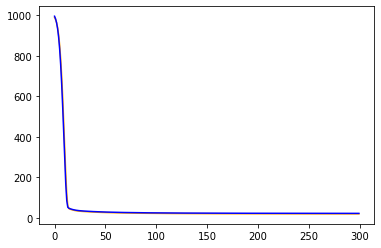

In [121]:
import matplotlib.pyplot as plt
plt.plot(res_train[1::2], color='orange')
plt.plot(res_valid, color='blue')
plt.show()

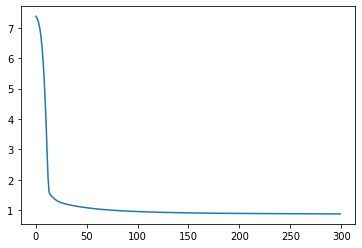

In [122]:
plt.plot(rmse)
plt.show()